In [2]:
import json, os
import numpy as np, matplotlib.pyplot as plt
import pandas as pd
import pickle
from house import House
import PIL
PIL.Image.MAX_IMAGE_PIXELS = None
#op = np.load(r'ims/orthophoto.npy')
#xmin, xmax, ymin, ymax = np.load(r'ims/orthophoto_coords.npy')
#nxop, nyop = op.shape[:-1]

header = ['ID', 'x', 'y', 'z', 'height2', 'rx', 'ry', 'rz',
          'pos1', 'pos2', 'pos3', 'att1', 'att2', 'att3', 'week', 'ToW', 'n_sat',
          'PDOP', 'lat', 'long', 'height']
aerial_photo = plt.imread(f'ims/aerial_photos/RGB/{(3 - len(str(94)))*str(0) + str(94)}.tif')
ny, nx = aerial_photo.shape[:-1]
metadata = pd.read_table(r'ims/aerial_photos/GNSSINS/EO_V355_TT-14525V_20210727_1.txt', comment='#', delim_whitespace=True, names=header)
metadata[['rx', 'ry', 'rz']] = metadata[['rx', 'ry', 'rz']].apply(np.deg2rad)
focal_length = int(100.5*1e-3/4e-6) # image coordinates
ppa = np.array((nx/2 - int(0.08*1e-3/4e-6), ny/2)) # image coordinates

with open('objects/camera_matrix1/houses.pickle', 'rb') as file:
    houses = pickle.load(file)

houses_ = list()

for i, house in enumerate(houses):
    if len(houses[i].image_ids)>1:
        houses_.append(house)
houses = houses_

with open('objects/camera_matrix1/coverage.pickle', 'rb') as file:
    coverage = pickle.load(file)

def RotationMatrix(rx, ry, rz):
    R1 = np.array([[1, 0, 0],
                   [0, np.cos(rx), -np.sin(rx)],
                   [0, np.sin(rx),np.cos(rx)]])
    
    R2 = np.array([[np.cos(ry), 0, np.sin(ry)],
                   [0, 1, 0],
                   [-np.sin(ry), 0, np.cos(ry)]])
    
    R3 = np.array([[np.cos(rz), -np.sin(rz), 0],
                   [np.sin(rz), np.cos(rz), 0],
                   [0, 0, 1]])
    
    return R1@R2@R3 


def UTM_to_image(X, C, x0, R, f):
    '''
    Calculates image coordinates using collinearity equations.

    X: Object positions in external coordinates. expects RGB dim as first shape dim, i.e. for N nodes, (3, N)
    C: Camera position in external coordinates
    x0: Focal point in image coordinates
    R: Perspective projection matrix from RotationMatrix()
    f: Focal length in image coordinates
    '''
    d = X-C.reshape(3, 1)
    denom = (R[0, 2]*d[0] + R[1, 2]*d[1] + R[2, 2]*d[2])
    img_coord = np.empty((2, X.shape[1]))
    img_coord[0] = x0[0] - f*(R[0, 0]*d[0] + R[1, 0]*d[1] + R[2, 0]*d[2])/denom
    img_coord[1] = ny - x0[1] + f*(R[0, 1]*d[0] + R[1, 1]*d[1] + R[2, 1]*d[2])/denom
    return img_coord

focal_length = int(100.5*1e-3/4e-6) # image coordinates
ppa = np.array((nx/2 - int(0.08*1e-3/4e-6), ny/2)) # image coordinates

def transform_house(house):
    image_corners = list()
    image_edges = list()
    for id in house.image_ids:
        cx, cy, cz, rx, ry, rz =  [metadata.loc[id][i] for i in ['x', 'y', 'z', 'rx', 'ry', 'rz']]
        R = RotationMatrix(rx, ry, rz)
        C = np.array((cx, cy, cz))
        image_corners.append(UTM_to_image(house.utm_coords, C, ppa, R, focal_length))
        edge_ = list()
        for edge in house.utm_edges:
            edge_.append(UTM_to_image(edge, C, ppa, R, focal_length))
        image_edges.append(edge_)
    
    return image_corners, image_edges 

image_ids_in_use = list()
for house in houses:
    for id in house.image_ids:
        if id not in image_ids_in_use:
            image_ids_in_use.append(id)
    
    corners, edges = transform_house(house)
    house.image_coords.append(corners)
    house.image_edges.append(edges)


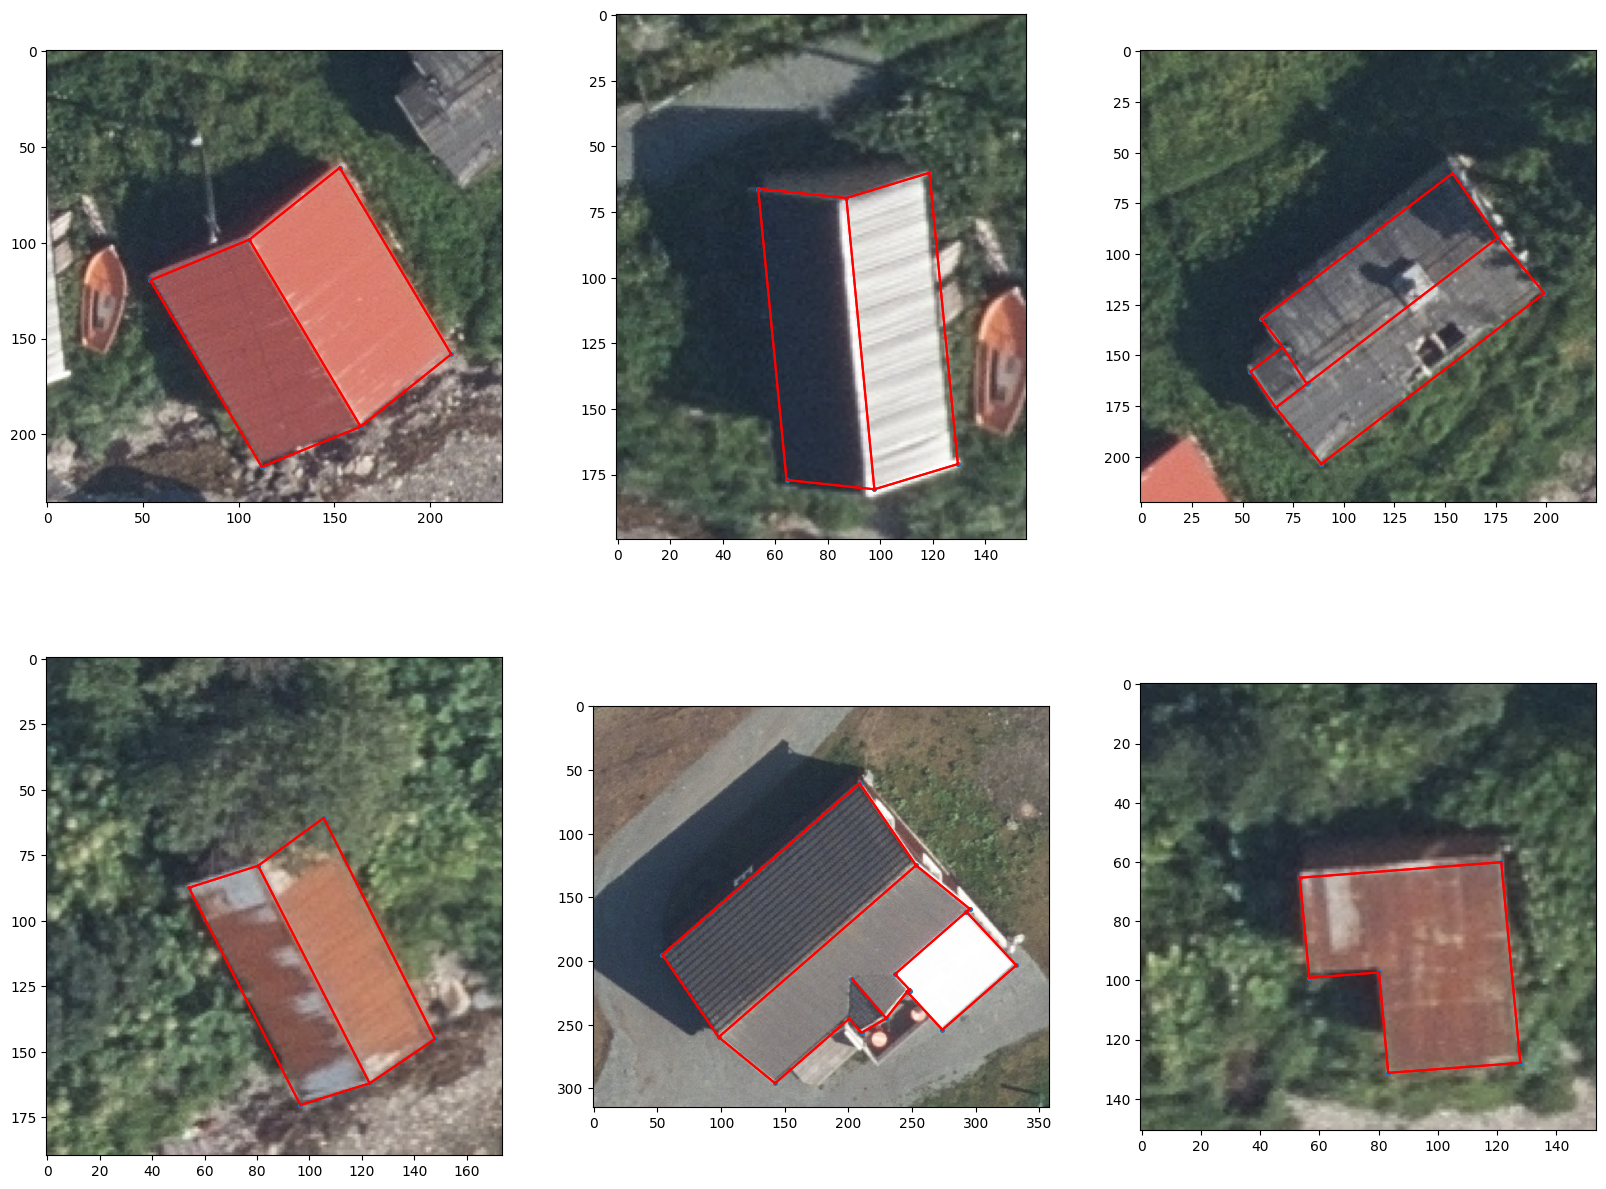

In [3]:
def check_alignment(ap_id, x_nudge=0, y_nudge=0, save=False):
    if save==False:
        _, axs = plt.subplots(2, 3, figsize=(20, 15))
    x_nudge, y_nudge = 13, 20
    pad = 40
    counter = 0
    corners_im = list()
    edges_im = list()
    for i, house in enumerate(houses):
        if ap_id-1 in house.image_ids:
            house_tr, edges_tr = transform_house(house)
            ids = np.array(house.image_ids )
            ind = np.where(ids==ap_id-1)[0][0]
            house_tr = house_tr[ind]
            edges_tr = edges_tr[ind]
            xmin, ymin = np.min(house_tr, axis=1).astype(int) 
            xmax, ymax = np.max(house_tr, axis=1).astype(int)
            #pad = int(min((xmax-xmin, ymax- ymin))/20)
            #print(pad)
            house_tr[0] = house_tr[0]-xmin+pad+x_nudge
            house_tr[1] = house_tr[1]-ymin+pad+y_nudge  
            if save==False:
                ax = axs.flatten()[counter] 
                ax.imshow(aerial_photo[ymin-pad:ymax+pad, xmin-pad:xmax+pad])
                ax.scatter(house_tr[0], house_tr[1], s=7)
            for i, edge in enumerate(edges_tr):
                for j in range(edge.shape[1]):
                    edges_tr[i][0, j] += -xmin+pad+x_nudge
                    edges_tr[i][1, j] += -ymin+pad+y_nudge
                    ax.plot([house_tr[0, i], edges_tr[i][0, j]], [house_tr[1, i], edges_tr[i][1, j]], c='red')
            corners_im.append(house_tr)
            #edges_im.append()
            if counter == 5 and save==False:
                break
            counter +=1
    plt.show()

check_alignment(94, x_nudge=0, y_nudge=0, save=False)

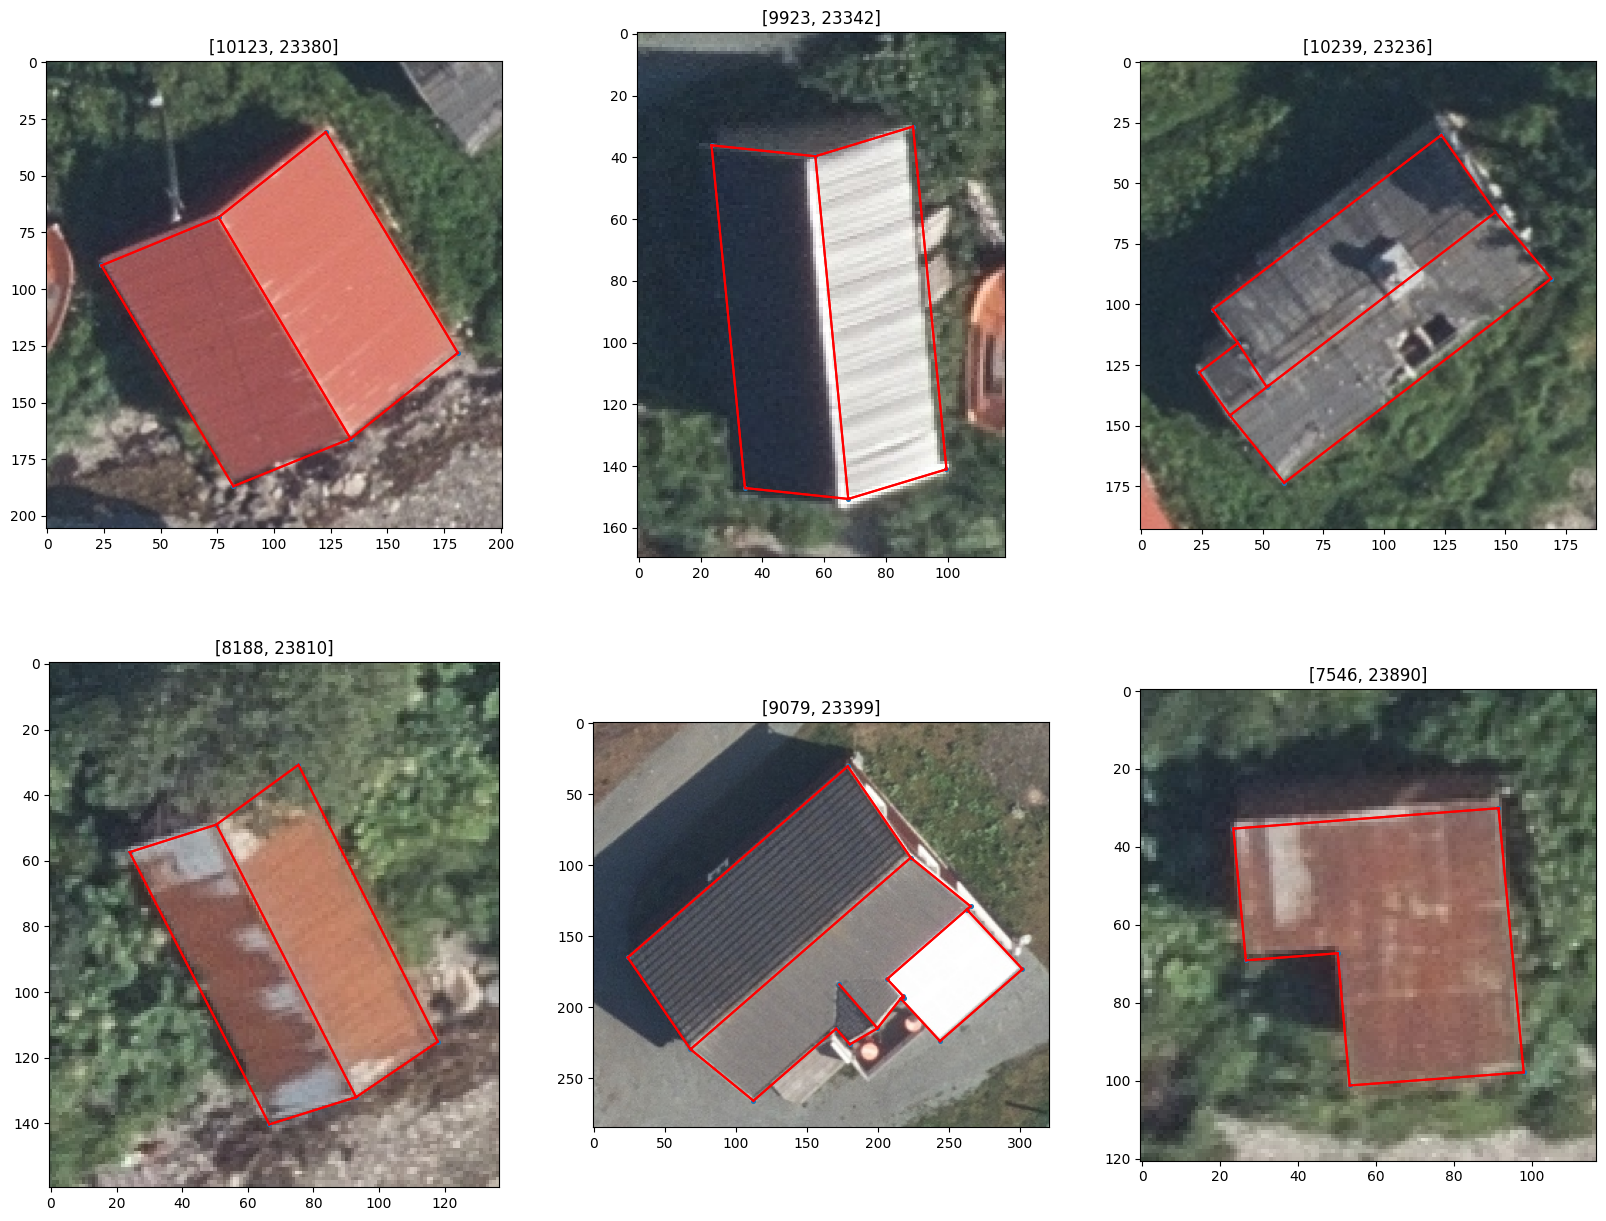

In [82]:
def check_alignment(ap_id, x_nudge=0, y_nudge=0, save=False, n_rows=3):
    if save==False:
        _, axs = plt.subplots(n_rows, 3, figsize=(5*n_rows, 15))
    x_nudge, y_nudge = 13, 20
    pad = 10
    counter = 0
    corners_im = list()
    edges_im = list()
    for i, house in enumerate(houses):
        if ap_id-1 in house.image_ids:
            house_tr, edges_tr = house.image_coords[0], house.image_edges[0]
            ids = np.array(house.image_ids)
            ind = np.where(ids==ap_id-1)[0][0]
            house_tr = house_tr[ind]
            edges_tr = edges_tr[ind]
            xmin, ymin = np.min(house_tr, axis=1).astype(int) 
            xmax, ymax = np.max(house_tr, axis=1).astype(int)
            #pad = int(min((xmax-xmin, ymax- ymin))/20)
            #print(pad)
            house_tr[0] = house_tr[0]-xmin+pad+x_nudge
            house_tr[1] = house_tr[1]-ymin+pad+y_nudge  
            if save==False:
                ax = axs.flatten()[counter] 
                ax.set_title([xmax, ymax])
                ax.imshow(aerial_photo[ymin-pad:ymax+2*pad + y_nudge, xmin-pad:xmax+2*pad + x_nudge])
                ax.scatter(house_tr[0], house_tr[1], s=7)
            for i, edge in enumerate(edges_tr):
                for j in range(edge.shape[1]):
                    edges_tr[i][0, j] += -xmin+pad+x_nudge
                    edges_tr[i][1, j] += -ymin+pad+y_nudge
                    ax.plot([house_tr[0, i], edges_tr[i][0, j]], [house_tr[1, i], edges_tr[i][1, j]], c='red')
            corners_im.append(house_tr)
            #edges_im.append()
            if counter == 5 and save==False:
                break
            counter +=1
    plt.show()

check_alignment(94, x_nudge=0, y_nudge=0, save=False)

In [2]:
fig, ax = plt.subplots()
plt.imshow(aerial_photo)


(17004, 26460)